In [2]:
!pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
  Using cached pip-23.3.1-py3-none-any.whl.metadata (3.5 kB)
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1


In [3]:
!pip install sagemaker ipywidgets --upgrade --quiet

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker-datawrangler 0.4.3 requires ipywidgets<8.0.0, but you have ipywidgets 8.1.1 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.


In [4]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [5]:
# Retrieve training artifacts

from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = "catboost-classification-model", "*", "training"
training_instance_type = "ml.m5.xlarge"

train_image_uri = image_uris.retrieve(region=None, framework=None, model_id=train_model_id, model_version=train_model_version, image_scope=train_scope, instance_type=training_instance_type)

train_source_uri = script_uris.retrieve(model_id=train_model_id, model_version=train_model_version, script_scope=train_scope)

train_model_uri = model_uris.retrieve(model_id=train_model_id, model_version=train_model_version, model_scope=train_scope)

In [6]:
# Specifying paths of training data and model output data

training_data_bucket = "csis-4495-tcga"
training_data_prefix = "train/"

training_dataset_s3_path = f"s3://{training_data_bucket}/{training_data_prefix}"

output_bucket = "sagemaker-tcga-catboost"
output_prefix = "tcga-catboost-jumpstart/"

s3_output_location = f"s3://{output_bucket}/{output_prefix}/output"

In [7]:
# Hyperparameters from local training
hyperparameters_bucket = "csis-4495-tcga"
hyperparameters_key = "hyperparameters"
hyperparameters_file_name = "hyperparameters.json"

boto3.client("s3").download_file(
    hyperparameters_bucket, f"{hyperparameters_key}/{hyperparameters_file_name}", hyperparameters_file_name
)

with open(hyperparameters_file_name) as fp:
    hyperparameters = json.load(fp)

hyperparameters

{'iterations': '677',
 'learning_rate': '0.14228961308206703',
 'l2_leaf_reg': '2',
 'random_strength': '5',
 'depth': '3',
 'colsample_bylevel': '0.07055489444086192',
 'min_data_in_leaf': '76'}

In [8]:
# Start training
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"jumpstart-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

tabular_estimator.fit(
    {"training": training_dataset_s3_path}, logs=False, job_name=training_job_name
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: jumpstart-catboost-classification-model-2023-11-25-19-54-43-623



2023-11-25 19:54:44 Starting - Starting the training job..
2023-11-25 19:54:59 Starting - Preparing the instances for training............
2023-11-25 19:56:08 Downloading - Downloading input data...
2023-11-25 19:56:27 Training - Downloading the training image.....
2023-11-25 19:56:57 Training - Training image download completed. Training in progress.......
2023-11-25 19:57:33 Uploading - Uploading generated training model.
2023-11-25 19:57:44 Completed - Training job completed


In [9]:
# Deploy and run inference on the trained model to test that the endpoint is working

inference_instance_type = "ml.m5.large"

deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)

deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = "tcga-catboost-endpoint"

predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-tcga-catboost/tcga-catboost-jumpstart//output/jumpstart-catboost-classification-model-2023-11-25-19-54-43-623/output/model.tar.gz), script artifact (s3://jumpstart-cache-prod-us-west-2/source-directory-tarballs/catboost/inference/classification/v1.1.2/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-west-2-031114635023/sagemaker-jumpstart-2023-11-25-19-57-51-075/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-11-25-19-57-51-075
INFO:sagemaker:Creating endpoint-config with name tcga-catboost-endpoint
INFO:sagemaker:Creating endpoint with name tcga-catboost-endpoint


-----!

In [10]:
# Download the validation data set for evaluation

validation_data_bucket = "csis-4495-tcga"
validation_data_prefix = "validation"
validation_data_file_name = "data.csv"

boto3.client("s3").download_file(
    validation_data_bucket, f"{validation_data_prefix}/{validation_data_file_name}", validation_data_file_name
)

In [11]:
# Testing the endpoint
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Read the data
test_data = pd.read_csv(validation_data_file_name, header=None)
test_data.columns = ["Target"] + [f"Feature+{i}" for i in range(1, test_data.shape[1])]

num_examples, num_columns = test_data.shape
print( f"The test dataset contains {num_examples} examples and {num_columns} columns.\n" )

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1], test_data.iloc[:, 1:]

print(f"The first 5 observations of the data: \n")
test_data.head(5)

The test dataset contains 1302 examples and 69 columns.

The first 5 observations of the data: 



,Target,Feature+1,Feature+2,Feature+3,Feature+4,Feature+5,Feature+6,Feature+7,Feature+8,Feature+9,...,Feature+59,Feature+60,Feature+61,Feature+62,Feature+63,Feature+64,Feature+65,Feature+66,Feature+67,Feature+68
0,2,0,52.150684,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,45.761642,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,70.038350,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,8,0,64.794520,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,7,0,65.835620,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
print(features.iloc[4, :].tolist())

[0.0, 65.83562, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


In [13]:
endpoint_name = "tcga-catboost-endpoint"

In [14]:
# Querying endpoint for further testing
content_type = "text/csv"

def query_endpoint(encoded_tabular_data):
    # endpoint_name = endpoint_name
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response

def parse_response(query_response):
    model_predictions = json.loads(query_response["Body"].read())
    predicted_probabilities = model_predictions["probabilities"]
    return np.array(predicted_probabilities)

# split the test data into smaller size of batches to query the endpoint due to the large size of test data.
batch_size = 500
predict_prob = []
for i in np.arange(0, num_examples, step=batch_size):
    query_response_batch = query_endpoint(
        features.iloc[i : (i + batch_size), :].to_csv(header=False, index=False).encode("utf-8")
    )
    predict_prob_batch = parse_response(query_response_batch)  # prediction probability per batch
    predict_prob.append(predict_prob_batch)


predict_prob = np.concatenate(predict_prob, axis=0)
predict_label = np.argmax(
    predict_prob, axis=1
)

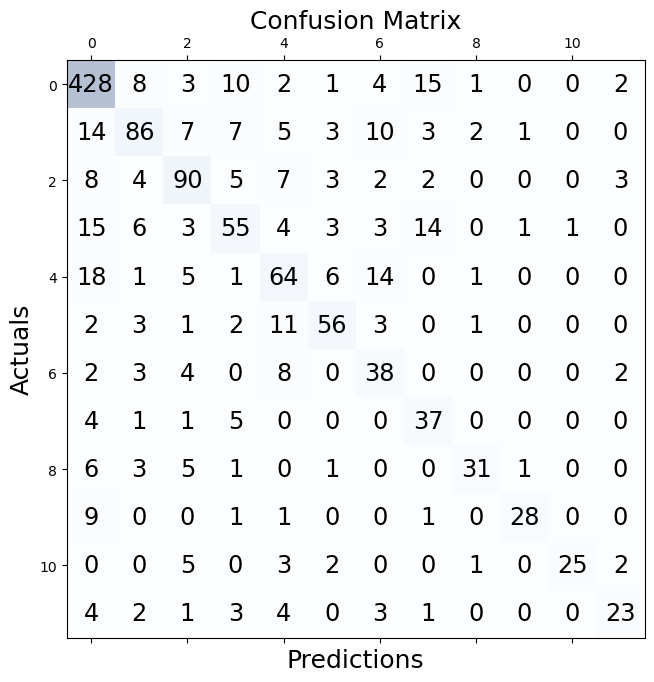

In [15]:
# Visualize the predictions results by plotting the confusion matrix.
conf_matrix = confusion_matrix(y_true=ground_truth_label.values, y_pred=predict_label)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va="center", ha="center", size="xx-large")

plt.xlabel("Predictions", fontsize=18)
plt.ylabel("Actuals", fontsize=18)
plt.title("Confusion Matrix", fontsize=18)
plt.show()

In [16]:
# Measure the prediction results quantitatively.
eval_accuracy = accuracy_score(ground_truth_label.values, predict_label)
eval_f1_macro = f1_score(ground_truth_label.values, predict_label, average="macro")
eval_f1_micro = f1_score(ground_truth_label.values, predict_label, average="micro")

print(
    f"Evaluation result on test data: \n"
    f"{accuracy_score.__name__}: {eval_accuracy} \n"
    f"F1 Macro: {eval_f1_macro} \n"
    f"F1 Micro: {eval_f1_micro}"
)

Evaluation result on test data: 
accuracy_score: 0.7380952380952381 
F1 Macro: 0.6876196515837893 
F1 Micro: 0.7380952380952381
